### Sum of Absolute Difference(SAD) along with Multi Block Matching

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal, ndimage
import time

class DisparityMap():
    def __init__(self, numDisparities, blockSize):
        self.numDisparities = numDisparities
        self.blockSize = blockSize
    
    def SAD(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        difference = []
        if len(imgL.shape) == 2:
            l, w = imgL.shape
            h = 1
        else:
            l, w, h = imgL.shape
        
        for i in range(self.numDisparities):            
            temp = np.zeros(imgL.shape, dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            temp = ndimage.uniform_filter(temp, self.blockSize)
            for i in range(1, h):
                temp[:, :, 0] += temp[:, :, i]
            if len(imgL.shape)==2:
                difference.append(temp.copy())
            else:
                difference.append(temp[:, :, 0].copy())

        difference = np.array(difference)

        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(difference[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap

    def SAD_with_MBM(self, imgL, imgR):
        imgL = imgL.astype(np.float)/255
        imgR = imgR.astype(np.float)/255
        
        kernel_61_1 = np.ones((61, 1))
        kernel_1_61 = np.ones((1, 61))
        kernel_11_11 = np.ones((11, 11))
        kernel_3_3 = np.ones((3, 3))
        
        errors_61_1 = []
        errors_1_61 = []
        errors_11_11 = []
        errors_3_3 = []
        
        if len(imgL.shape) == 2:
            l, w = imgL.shape
            h = 1
        else:
            l, w, h = imgL.shape
        
        for i in range(self.numDisparities):
            temp = np.zeros(imgL.shape, dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            
            if len(imgL.shape)==2:
                error_61_1 = signal.convolve2d(temp, kernel_61_1, boundary='symm', mode='same')/61
                error_1_61 = signal.convolve2d(temp, kernel_1_61, boundary='symm', mode='same')/61
                error_11_11 = signal.convolve2d(temp, kernel_11_11, boundary='symm', mode='same')/121
                error_3_3 = signal.convolve2d(temp, kernel_3_3, boundary='symm', mode='same')/9
            else:
                error_61_1 = np.zeros((l, w))
                error_1_61 = np.zeros((l, w))
                error_11_11 = np.zeros((l, w))
                error_3_3 = np.zeros((l, w))
                for j in range(h):
                    error_61_1 += signal.convolve2d(temp[:, :, j], kernel_61_1, boundary='symm', mode='same')/61
                    error_1_61 += signal.convolve2d(temp[:, :, j], kernel_1_61, boundary='symm', mode='same')/61
                    error_11_11 += signal.convolve2d(temp[:, :, j], kernel_11_11, boundary='symm', mode='same')/121
                    error_3_3 += signal.convolve2d(temp[:, :, j], kernel_3_3, boundary='symm', mode='same')/9
            
            errors_61_1.append(error_61_1.copy())
            errors_1_61.append(error_1_61.copy())
            errors_11_11.append(error_11_11.copy())
            errors_3_3.append(error_3_3.copy())
        
        errors_61_1 = np.array(errors_61_1)
        errors_1_61 = np.array(errors_1_61)
        errors_11_11 = np.array(errors_11_11)
        errors_3_3 = np.array(errors_3_3)
        
        errors_61_1 = np.minimum(errors_61_1, errors_1_61)
        out = np.multiply(errors_61_1, errors_11_11)
        out = np.multiply(out, errors_3_3)
        
        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(out[:,i,j])
        return disparityMap
    
    #For this function, you can give miltiple different sized input kernels
    def SAD_with_input_kernels(self, imgL, imgR, kernels):
        imgL = imgL.astype(np.float)/255
        imgR = imgR.astype(np.float)/255
        
        global errors
        errors = [[] for i in range(len(kernels))]
        
        if len(imgL.shape) == 2:
            l, w = imgL.shape
            h = 1
        else:
            l, w, h = imgL.shape
            
        for i in range(self.numDisparities):
            temp = np.zeros(imgL.shape, dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            
            error = [[] for _ in range(len(kernels))]
            for ker in range(len(kernels)):
                kx, ky = kernels[ker].shape
                
                if len(imgL.shape)==2:
                    error[ker] = signal.convolve2d(temp, kernels[ker], boundary='symm', mode='same')/(kx*ky)
                else:
                    error[ker] = np.zeros((l, w))
                    for j in range(h):
                        error[ker] += signal.convolve2d(temp[:, :, j], kernels[ker], boundary='symm', mode='same')/(kx*ky)                    
                
            for ker in range(len(kernels)):
                errors[ker].append(error[ker].copy())
        
        for ker in range(len(kernels)):
            errors[ker] = np.array(errors[ker])
        
        out = errors[0]
        for i in range(1, len(kernels)):
            out = np.multiply(out, errors[i])
        
        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(out[:,i,j])
        return disparityMap
    
    #Generating Locally Consistent Disparity Map, to remove noise and fill in blank pixels based on the surrounding neighbours pixels
    def LCDM(self, disparityMap, kernel):
        disparityMap = disparityMap.astype(np.int64)
        output = disparityMap.copy()
        r, c = disparityMap.shape
        row_mid, col_mid = kernel[0]//2, kernel[1]//2
        
        for i in range(2*row_mid, r-2*row_mid):
            for j in range(2*col_mid, min(c-numdisparities-col_mid, c-2*col_mid)):
                temp = disparityMap[i-row_mid:i+row_mid+1, j-col_mid:j+col_mid+1]
                val = np.bincount(temp.reshape(1, kernel[0]*kernel[1])[0]).argmax()
                output[i, j] = val
        return output

In [43]:
## Input data

# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)
# ground_truth = cv2.imread('tsukuba_r.png', 0)

imgL = cv2.imread('2001/cones/im2.png', 0)
imgR = cv2.imread('2001/cones/im6.png', 0)
ground_truth = cv2.imread('2001/cones/disp6.png', 0)/4

# imgL = cv2.imread('2001/teddy/im2.png', 0)
# imgR = cv2.imread('2001/teddy/im6.png', 0)
# ground_truth = cv2.imread('2001/teddy/disp6.png', 0)/4

# imgL = cv2.imread('2001/sawtooth/im2.ppm', 0)
# imgR = cv2.imread('2001/sawtooth/im6.ppm', 0)
# ground_truth = cv2.imread('2001/sawtooth/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/venus/im2.ppm', 0)
# imgR = cv2.imread('2001/venus/im6.ppm', 0)
# ground_truth = cv2.imread('2001/venus/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/barn1/im2.ppm', 0)
# imgR = cv2.imread('2001/barn1/im6.ppm', 0)
# ground_truth = cv2.imread('2001/barn1/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/bull/im2.ppm', 0)
# imgR = cv2.imread('2001/bull/im6.ppm', 0)
# ground_truth = cv2.imread('2001/bull/disp6.pgm', 0)/8

In [44]:
#Blurring the image using Gaussian filter to remove noise from the input image
imgLg = cv2.GaussianBlur(imgL, (3,3), cv2.BORDER_DEFAULT)
imgRg = cv2.GaussianBlur(imgR, (3,3), cv2.BORDER_DEFAULT)

#Finding gradients along x and y direction for both left and right images
imgLx = cv2.Sobel(imgL, cv2.CV_64F, 1, 0, ksize=3)
imgLy = cv2.Sobel(imgL, cv2.CV_64F, 0, 1, ksize=3)

imgRx = cv2.Sobel(imgR, cv2.CV_64F, 1, 0, ksize=3)
imgRy = cv2.Sobel(imgR, cv2.CV_64F, 0, 1, ksize=3)

#Creating new multi dimensional image
imgLxy = np.zeros((imgL.shape[0], imgL.shape[1], 3), np.float64)
imgLxy[:,:,0] = imgL
imgLxy[:,:,1] = imgLx
imgLxy[:,:,2] = imgLy

imgRxy = np.zeros((imgR.shape[0], imgR.shape[1], 3), np.float64)
imgRxy[:,:,0] = imgR
imgRxy[:,:,1] = imgRx
imgRxy[:,:,2] = imgRy

#Applying the algorithm
blocksize = 11
numdisparities = 64
disparity = DisparityMap(numDisparities=numdisparities, blockSize=blocksize)

t1 = time.time()
disparityMap1 = disparity.SAD(imgL, imgR)
t2 = time.time()
print(t2-t1)
disparityMap2 = disparity.LCDM(disparityMap1, (11, 11))

t1 = time.time()
disparityMap3 = disparity.SAD_with_MBM(imgL, imgR)
t2 = time.time()
print(t2-t1)
disparityMap4 = disparity.LCDM(disparityMap3, (11, 11))

0.5759663581848145
10.641172885894775


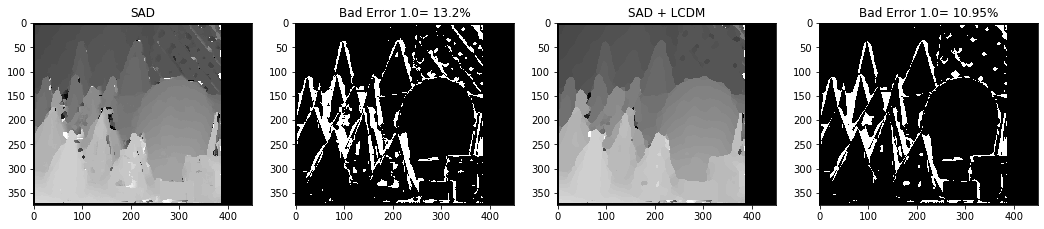

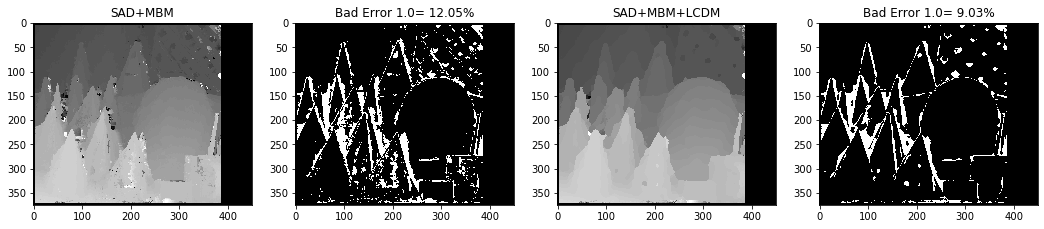

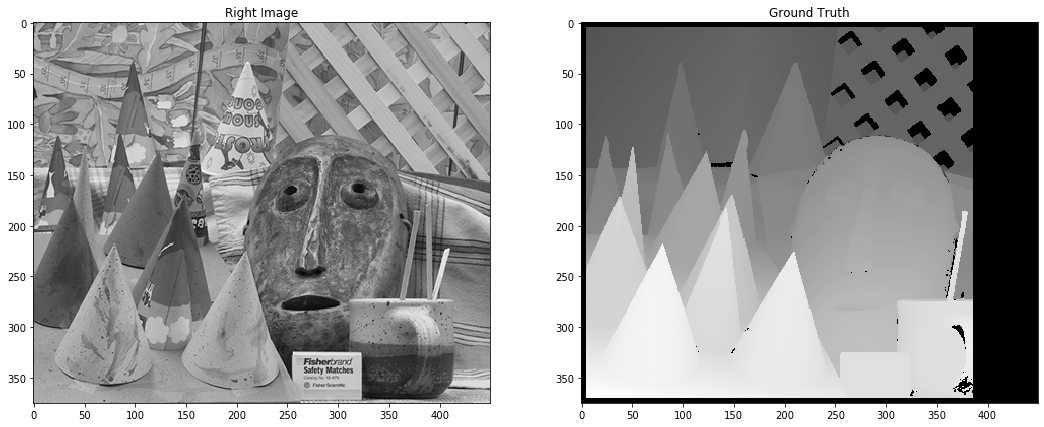

In [47]:
###############################################################
##Cropping the ground truth
r, c = ground_truth.shape
ground_truth[:int(blocksize/2), :] = 0
ground_truth[:, :int(blocksize/2)] = 0
ground_truth[r-int(blocksize/2):, :] = 0
ground_truth[:, c-numdisparities:] = 0

##Calculating error
error1 = (abs(ground_truth-disparityMap1)>1) & (ground_truth!=0)
error_per1 = np.round(100*sum(error1.reshape(r*c, 1))[0]/(r*c), 2)

error2 = (abs(ground_truth-disparityMap2)>1) & (ground_truth!=0)
error_per2 = np.round(100*sum(error2.reshape(r*c, 1))[0]/(r*c), 2)

error3 = (abs(ground_truth-disparityMap3)>1) & (ground_truth!=0)
error_per3 = np.round(100*sum(error3.reshape(r*c, 1))[0]/(r*c), 2)

error4 = (abs(ground_truth-disparityMap4)>1) & (ground_truth!=0)
error_per4 = np.round(100*sum(error4.reshape(r*c, 1))[0]/(r*c), 2)

##################################################################
plt.figure(figsize=(18, 72))
plt.subplot(141)
plt.imshow(disparityMap1, 'gray')
plt.title('SAD')

plt.subplot(142)
plt.imshow(error1, 'gray')
plt.title('Bad Error 1.0= '+str(error_per1)+'%')

plt.subplot(143)
plt.imshow(disparityMap2, 'gray')
plt.title('SAD + LCDM')

plt.subplot(144)
plt.imshow(error2, 'gray')
plt.title('Bad Error 1.0= '+str(error_per2)+'%')
plt.show()

##################################
plt.figure(figsize=(18, 72))
plt.subplot(141)
plt.imshow(disparityMap3, 'gray')
plt.title('SAD+MBM')

plt.subplot(142)
plt.imshow(error3, 'gray')
plt.title('Bad Error 1.0= '+str(error_per3)+'%')

plt.subplot(143)
plt.imshow(disparityMap4, 'gray')
plt.title('SAD+MBM+LCDM')

plt.subplot(144)
plt.imshow(error4, 'gray')
plt.title('Bad Error 1.0= '+str(error_per4)+'%')
plt.show()

###################################################################
plt.figure(figsize=(18, 27))
plt.subplot(121)
plt.imshow(imgR, 'gray')
plt.title('Right Image')

plt.subplot(122)
plt.imshow(ground_truth, 'gray')
plt.title('Ground Truth')
plt.show()